In [1]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

import pickle

import numpy as np

import pandas as pd

% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

import joblib

from libs.container import Container
from libs.display import d
from libs.experiment import KFoldExperiment, WithAnotherExperiment, roc

In [2]:
cpu = joblib.cpu_count()

In [3]:
sample = pd.read_pickle("data/scaled/sample.pkl.bz2")
sample["tile"] = sample["id"].apply(lambda i: "b" + str(i)[1:4])

no_features = ["id", "vs_catalog", "vs_type", "ra_k", "dec_k", "tile", "cls"] 
X_columns = [c for c in sample.columns if c not in no_features]

grouped = sample.groupby("tile")
data = Container({k: grouped.get_group(k).copy() for k in grouped.groups.keys()})
data = Container(data=pd.concat([data.b278, data.b261]))

cls = {name: idx for idx, name in enumerate(data.data.tile.unique())}
data.data["cls"] = data.data.tile.apply(cls.get)

del grouped, sample

cls

{'b261': 1, 'b278': 0}

In [4]:
cls = {v: v for v in cls.values()}

In [5]:
RF_PARAMS = {
    'max_features': .5, 'min_samples_split': 10, 'n_jobs': cpu, 
    'criterion': 'entropy', 'n_estimators': 500}

In [6]:
X = data.data[X_columns].values
y = data.data.cls.values

In [7]:
%%time
clf = RandomForestClassifier(**RF_PARAMS)
sel = RFECV(clf, n_jobs=cpu, cv=10)
sel.fit(X, y)

CPU times: user 31min 22s, sys: 7.63 s, total: 31min 30s
Wall time: 25min 18s


In [23]:
df = pd.DataFrame({
    "Feature": X_columns, 
    "Selected": sel.support_, "Ranking": sel.ranking_, "Scores": sel.grid_scores_})
df = df.reset_index(drop=True)
df.to_pickle("data/ranking.pkl.bz2", compression="bz2")

In [24]:
print("Selected Features: ", sum(df.Selected.values))

Selected Features:  6


In [25]:
def is_selected(row):
    if row.Selected:
        return pd.Series('background-color: #7EA489', row.index)
    return pd.Series('', row.index)


with pd.option_context('display.precision', 4):
    html = df.sort_values("Ranking").style.apply(is_selected, axis=1)
html

,Feature,Ranking,Scores,Selected
26,MaxSlope,1,0.8633,True
49,cnt,1,0.8603,True
47,c89_m2,1,0.8598,True
27,Mean,1,0.8628,True
33,PercentDifferenceFluxPercentile,1,0.8598,True
11,Eta_e,1,0.8673,True
48,c89_m4,2,0.8608,False
7,CAR_mean,3,0.8688,False
38,Q31,4,0.8583,False
39,Rcs,5,0.8593,False


In [26]:
sel.score(X, y)

0.97487437185929648

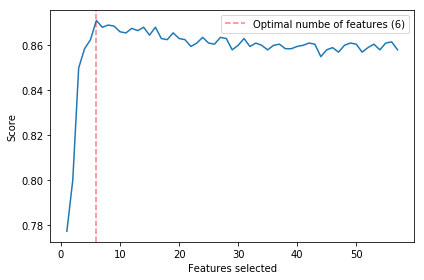

In [28]:
plt.figure()
plt.xlabel("Features selected")
plt.ylabel("Score")
plt.plot(range(1, len(sel.grid_scores_) + 1), sel.grid_scores_)
plt.axvline(df.Selected.sum(), c="r", alpha=0.5, ls="--", label=u"Optimal numbe of features ({})".format(df.Selected.sum()))
plt.legend()
plt.tight_layout()
plt.savefig("plots/rfe.pdf")
plt.show()

In [29]:
sX_columns = df[df.Selected].Feature.values

In [30]:
%%time
rf = KFoldExperiment(
    clf=RandomForestClassifier(**RF_PARAMS), clsnum=cls, 
    data=data, pcls=1, ncls=0, X_columns=sX_columns, y_column="cls")
rf = rf("data", nfolds=10)

              precision    recall  f1-score   support

         0.0       0.85      0.91      0.87       994
         1.0       0.90      0.83      0.87       996

   micro avg       0.87      0.87      0.87      1990
   macro avg       0.87      0.87      0.87      1990
weighted avg       0.87      0.87      0.87      1990

--------------------------------------------------------------------------------
CPU times: user 1min 21s, sys: 2.69 s, total: 1min 23s
Wall time: 24.4 s


In [31]:
list(sX_columns)

['Eta_e',
 'MaxSlope',
 'Mean',
 'PercentDifferenceFluxPercentile',
 'c89_m2',
 'cnt']

In [32]:
rf_all = np.load("data/results/model_selection.pkl.npy")[0]

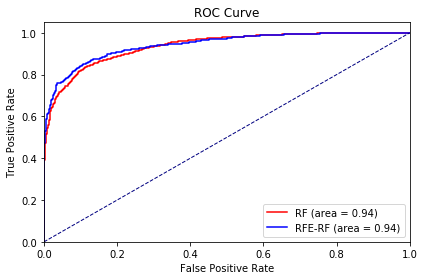

In [33]:
ax = roc({"RFE-RF": rf, "RF": rf_all});
ax.get_children()[0].set_color("red")
ax.get_children()[1].set_color("blue")
plt.legend()

plt.tight_layout()
plt.savefig("plots/rfe_vs_all.pdf")

In [34]:
print(
    pd.DataFrame([
        ["RF", rf_all.prec_rec[0], rf_all.prec_rec[1], rf_all.roc_auc],
        ["RFE-RF", rf.prec_rec[0], rf.prec_rec[1], rf.roc_auc]],
        columns="Modelo Precision Recall AUC".split()
    ).to_latex(index=False, float_format="%.4f"))

\begin{tabular}{lrrr}
\toprule
 Modelo &  Precision &  Recall &    AUC \\
\midrule
     RF &     0.8852 &  0.8283 & 0.9365 \\
 RFE-RF &     0.8984 &  0.8343 & 0.9419 \\
\bottomrule
\end{tabular}

